In [2]:
%cd ../..

c:\Users\yanic\dev\ethz\cil\CIL2023


# Mask Angle Distance Width Transform
Transforms binary masks to corresponding (angle,distance,width)-masks where each pixel points to the closest center of the street (using polar coordinates) and how wide it believes the street to be at that point. The output will then be concatenated as with the original mask as 3 extra channels.

#### Important Note: All lengths are in pixel coordinates! If you resize the image, then obviously you need to rescale the values too!

### Config

In [3]:
PADDING = 25
SMOOTH_ANGLE = 2.0 # None to disable
SMOOTH_WIDTH = 1.0 # None to disable
SMOOTH_MASK_ITERATIONS = 3

NORM_ANGLE_M, NORM_ANGLE_STD = 0.0, 1.0
NORM_DISTANCE_M, NORM_DISTANCE_STD = 0.0, 1.0
NORM_WIDTH_M, NORM_WIDTH_STD = 0.0, 1.0

# the image size that the model will be working on (matters for distance prediction!)
TARGET_SIZE = (400,400) 
# leave at (400,400) if doing cropping
# use (224,224) if rescaling

### SRC

In [4]:
import os

import matplotlib.pyplot as plt
from numpy import real, imag
from PIL import ImageDraw as draw, Image

import torchvision
from torchvision.io import ImageReadMode

import numpy as np
import torch
import torch.nn.functional as F

from skimage.morphology import medial_axis, skeletonize
from scipy.ndimage import distance_transform_edt, gaussian_filter, binary_erosion, binary_closing
from numpy import angle as anglef

from joblib import Parallel, delayed

In [5]:
def mask_to_distance_angle_width(mask: np.ndarray, padding: int = 25, smooth_mask_iterations: int = 3,
                          smooth_angle : float = None, smooth_width: float = None, 
                          return_skeleton: bool = False,
                          normalize_angle_mean: float = 0.0, normalize_angle_std: float = 1.0,
                          normalize_distance_mean: float = 0.0, normalize_distance_std: float = 1.0,
                          normalize_width_mean: float = 0.0, normalize_width_std: float = 1.0):
    """ 
        Takes a binary mask and computes a representation in (distance, angle, width)-space.
            - distance is the distance of each pixel to the closest pixel on the skeleton
            - angle is the angle to the closest pixel on the skeleton
            - width is the width of the mask at the closest pixel on the skeleton

        Returns the computed representation as a tuple (individual masks have the same size as the original)
        
        Parameters
        ----------
        mask
            A grayscale image (as numpy array)
        padding
            By how many pixels should the mask be extended when computing the skeleton (stabilizes boundaries)
        smooth_mask_iterations
            How often should closing (dilation followed by erosion) be applied to the image? 
            (can improve skeleton quality by smoothing edges)
        smooth_angle
            stddev to use for gaussian blurring of angle mask
        smooth_width
            stddev to use for gaussian blurring of width mask
        return_skeleton
            Should the intermediate skeleton be returned as well
        normalize_<r|angle|width>_mean:
            Mean of distribution (will be subtracted)
        normalize_<r|angle|width>_std:
            Standard deviation of distribution (will divide by this)
    """
    mask = F.pad(torch.Tensor(mask).unsqueeze(0), pad=(padding,padding,padding,padding), mode='replicate').squeeze().numpy()

    # removes minor edges that cause additional branch in skeleton
    mask = binary_closing(mask, iterations=smooth_mask_iterations)
    mask = 1.0 * mask # convert to float

    # perform skeletonization
    skeleton = skeletonize(mask, method='zhang') # lee does not work for lower resolutions
    # skeleton = medial_axis(mask) # medial_axis does not work as good for lower resolution!

    # compute distance to edge of road
    # dist_to_edge = distance_transform_edt(binary_erosion(mask))
    outline = mask - binary_erosion(mask) # using this, so we don't lose very thin connections
    dist_to_edge = distance_transform_edt(1.0 - outline)

    # compute distance to center of road
    distance, idx_center = distance_transform_edt(1.0 - skeleton, return_indices=True)

    # the width of the road a pixel belongs to
    h,w = mask.shape
    width = np.zeros(shape=(h,w))
    for y in range(h):
        for x in range(w):
            width[y,x] = dist_to_edge[idx_center[0][y,x], idx_center[1][y,x]]

    if smooth_width:
        width = gaussian_filter(width, smooth_width)

    h,w = distance.shape
    grid = np.linspace(0,h-1,h).reshape(h,1)
    y = idx_center[0] - grid
    x = idx_center[1] - grid.T

    c = x+1j * y
    angle = anglef(c)
    if smooth_angle:
        angle = gaussian_filter(angle, smooth_angle)
    
    # d = abs(c) # does not improve quality

    distance = distance[padding:-padding, padding:-padding]
    angle = angle[padding:-padding, padding:-padding]
    width = width[padding:-padding, padding:-padding]

    # normalization
    distance = (distance - normalize_distance_mean) / normalize_distance_std
    angle = (angle - normalize_angle_mean) / normalize_angle_std
    width = (width - normalize_width_mean) / normalize_width_std

    if not return_skeleton:
        return distance, angle, width
    else:
        skeleton = skeleton[padding:-padding, padding:-padding]
        return distance, angle, width, skeleton

# Generate Data

In [6]:
COLLECT_METRICS = True
dataset_folder = 'data/training'
input_folder = os.path.join(dataset_folder, 'groundtruth')
output_folder = os.path.join(dataset_folder, 'transformed')

madw_folder = os.path.join(output_folder, 'mask_angle_distance_width')
os.makedirs(madw_folder, exist_ok=True)

In [7]:
def process(i, img_name):
    full_path = os.path.join(input_folder, img_name)
    descriptor = img_name.split('.')[0]
    mask = torchvision.io.read_image(full_path, mode=ImageReadMode.GRAY)/255.0
    mask = F.interpolate(input=mask.unsqueeze(0), size=TARGET_SIZE).squeeze(0)
    mask = mask.squeeze().numpy()

    distance, angle, width = mask_to_distance_angle_width(mask, padding=PADDING, smooth_angle=SMOOTH_ANGLE, smooth_width=SMOOTH_WIDTH)

    madw = np.stack([mask, angle, distance, width]).astype(np.float16)
    np.save(os.path.join(madw_folder, f'{descriptor}'), madw)

In [8]:
r = Parallel(n_jobs=8)(delayed(process)(i, img_name) for i,img_name in enumerate(os.listdir(input_folder)))

# Experiments

In [61]:
mask = torchvision.io.read_image('data/training/groundtruth/satimage_53.png', mode=ImageReadMode.GRAY)/255.0
dist,angle,width,skeleton = mask_to_distance_angle_width(mask, PADDING, SMOOTH_MASK_ITERATIONS, SMOOTH_ANGLE, SMOOTH_WIDTH, True, NORM_ANGLE_M, NORM_ANGLE_STD, NORM_DISTANCE_M, NORM_DISTANCE_STD, NORM_WIDTH_M, NORM_WIDTH_STD)

plt.imshow(mask[0])
plt.show()
plt.imshow(angle)
plt.show()
plt.imshow(dist)
plt.show()
plt.imshow(width)
plt.show()


In [56]:
def reconstruct_naive(weight,distance,angle,width,padding=25):
    h,w = distance.shape
    ph,pw = 2*padding+h, 2*padding+w
    cartesian_center = distance * np.exp(1j * angle) # relative cartesian coordinates of center

    grid = np.linspace(0,h-1,h).reshape(h,1)
    cartesian_center += (padding + grid.T) + 1j * (padding + grid)
    center_y = imag(cartesian_center)
    center_x = real(cartesian_center)

    # Crop to bounds
    center_y[center_y < 0] = 0
    center_y[center_y >= ph] = ph - 1
    center_x[center_x < 0] = 0
    center_x[center_x >= pw] = pw - 1

    votes = np.zeros(shape=(ph,pw,2))
    for y in range(h):
        for x in range(w):
            cy = int(center_y[y,x])
            cx = int(center_x[y,x])
            
            votes[cy,cx,0] += weight[y,x] * width[y,x]
            votes[cy,cx,1] += weight[y,x]

    avg = votes[:,:,0] / votes[:,:,1]
    avg[np.isnan(avg)] = 0.0

    out = Image.new(mode='L', size=(ph,pw))
    out_d = draw.Draw(out)

    for y in range(ph):
        for x in range(pw):
            distance = round(avg[y,x])
            out_d.ellipse(xy=((x-distance,y-distance), (x+distance,y+distance)), fill=255)

    out = np.array(out) / 255.0
    return out[padding:-padding, padding:-padding]

# does not require a mask because we treat each center that was only voted for by < min_vote_threshold as an outlier
def reconstruct_naive_no_mask(distance, angle, width, padding=25, min_vote_threshold=5):
    h,w = distance.shape
    ph,pw = 2*padding+h, 2*padding+w
    cartesian_center = distance * np.exp(1j * angle) # relative cartesian coordinates of center

    grid = np.linspace(0,h-1,h).reshape(h,1)
    cartesian_center += (padding + grid.T) + 1j * (padding + grid)
    center_y = imag(cartesian_center)
    center_x = real(cartesian_center)

    # Crop to bounds
    center_y[center_y < 0] = 0
    center_y[center_y >= ph] = ph - 1
    center_x[center_x < 0] = 0
    center_x[center_x >= pw] = pw - 1

    total_width = np.zeros(shape=(ph,pw))
    nr_votes = np.zeros(shape=(ph,pw))
    for y in range(h):
        for x in range(w):
            cy = int(center_y[y,x])
            cx = int(center_x[y,x])
            
            total_width[cy,cx] += width[y,x]
            nr_votes[cy,cx] += 1.0

    avg = total_width / nr_votes # the average voted width at each pixel
    avg[np.isnan(avg)] = 0.0

    out = Image.new(mode='L', size=(ph,pw))
    out_d = draw.Draw(out)

    for y in range(ph):
        for x in range(pw):
            distance = round(avg[y,x])
            if nr_votes[y,x] > min_vote_threshold:
                out_d.ellipse(xy=((x-distance,y-distance), (x+distance,y+distance)), fill=255)

    out = np.array(out) / 255.0
    return out[padding:-padding, padding:-padding]

C:\Users\yanic\AppData\Local\Temp\ipykernel_3708\2239584175.py:67: RuntimeWarning: invalid value encountered in divide
  avg = total_width / nr_votes # the average voted width at each pixel


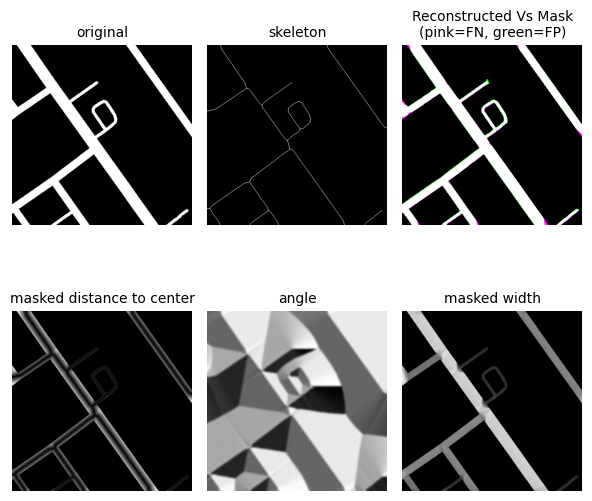

In [58]:
# bad examples: 0, 69, 143
mask = torchvision.io.read_image('data/training/groundtruth/satimage_53.png', mode=ImageReadMode.GRAY)/255
mask = F.interpolate(input=mask.unsqueeze(0), size=TARGET_SIZE).squeeze(0)
mask = mask.squeeze().numpy()

distance, angle, width, skeleton = mask_to_distance_angle_width(mask, padding=PADDING, smooth_angle=SMOOTH_ANGLE, smooth_width=SMOOTH_WIDTH, return_skeleton=True)
#out = reconstruct_naive(mask, r, angle, width, padding=pad) # only use this if we have good quality masks from the model
# plt.imshow(reconstruct_naive(np.rot90(distance), np.rot90(angle), np.rot90(width), padding=pad, min_vote_threshold=7))
# plt.show()

out = reconstruct_naive_no_mask(distance, angle, width, padding=PADDING, min_vote_threshold=7)


# display results
fig, axes = plt.subplots(2, 3, figsize=(6, 6))

h,w = out.shape
rgb = np.zeros(shape=(h,w,3))
rgb[:,:,0] = mask
rgb[:,:,1] = out
rgb[:,:,2] = mask

axes[0,0].imshow(mask, cmap=plt.cm.gray)
axes[0,0].axis('off')
axes[0,0].set_title('original', fontsize=10)

axes[0,1].imshow(skeleton, cmap=plt.cm.gray)
axes[0,1].axis('off')
axes[0,1].set_title('skeleton', fontsize=10)

axes[0,2].imshow(rgb, cmap='gray')
axes[0,2].axis('off')
axes[0,2].set_title('Reconstructed Vs Mask\n(pink=FN, green=FP)', fontsize=10)

axes[1,0].imshow(distance * mask, cmap=plt.cm.gray)
axes[1,0].axis('off')
axes[1,0].set_title('masked distance to center', fontsize=10)

axes[1,1].imshow(angle, cmap=plt.cm.gray)
axes[1,1].axis('off')
axes[1,1].set_title('angle', fontsize=10)

axes[1,2].imshow(width * mask, cmap=plt.cm.gray)
axes[1,2].axis('off')
axes[1,2].set_title('masked width', fontsize=10)

fig.tight_layout()
plt.show()


## Reconstruction With Noise

C:\Users\yanic\AppData\Local\Temp\ipykernel_3708\2239584175.py:67: RuntimeWarning: invalid value encountered in divide
  avg = total_width / nr_votes # the average voted width at each pixel


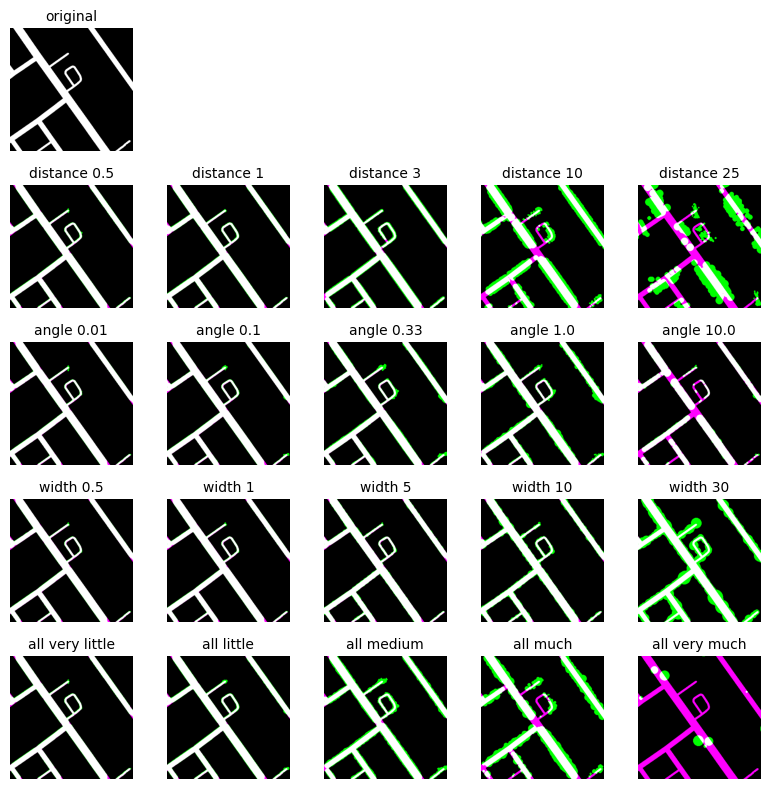

In [60]:
from numpy import random

h,w = distance.shape
noise = lambda min,max: random.random(size=(h,w)) * (max - min) + min
snoise = lambda v: noise(-v,v)

def plot_error(ax,title,out):
    rgb = np.zeros(shape=(h,w,3))
    rgb[:,:,0] = mask
    rgb[:,:,1] = out
    rgb[:,:,2] = mask

    ax.imshow(rgb)
    ax.axis('off')
    ax.set_title(title, fontsize=10)

fig, axes = plt.subplots(5, 5, figsize=(8, 8))

axes[0,0].imshow(mask, cmap=plt.cm.gray)
axes[0,0].axis('off')
axes[0,0].set_title('original', fontsize=10)
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')
axes[0,4].axis('off')

plot_error(axes[1,0], 'distance 0.5',  reconstruct_naive_no_mask(distance + snoise(0.5), angle, width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[1,1], 'distance 1',    reconstruct_naive_no_mask(distance + snoise(1.0), angle, width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[1,2], 'distance 3',    reconstruct_naive_no_mask(distance + snoise(3.0), angle, width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[1,3], 'distance 10',   reconstruct_naive_no_mask(distance + snoise(10.0), angle, width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[1,4], 'distance 25',   reconstruct_naive_no_mask(distance + snoise(25.0), angle, width, padding=PADDING, min_vote_threshold=7))

plot_error(axes[2,0], 'angle 0.01',     reconstruct_naive_no_mask(distance, angle + snoise(0.01), width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[2,1], 'angle 0.1',      reconstruct_naive_no_mask(distance, angle + snoise(0.1), width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[2,2], 'angle 0.33',     reconstruct_naive_no_mask(distance, angle + snoise(0.33), width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[2,3], 'angle 1.0',      reconstruct_naive_no_mask(distance, angle + snoise(1.0), width, padding=PADDING, min_vote_threshold=7))
plot_error(axes[2,4], 'angle 10.0',     reconstruct_naive_no_mask(distance, angle + snoise(10.0), width, padding=PADDING, min_vote_threshold=7))


plot_error(axes[3,0], 'width 0.5',  reconstruct_naive_no_mask(distance, angle, width + snoise(0.5), padding=PADDING, min_vote_threshold=7))
plot_error(axes[3,1], 'width 1',    reconstruct_naive_no_mask(distance, angle, width + snoise(1.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[3,2], 'width 5',    reconstruct_naive_no_mask(distance, angle, width + snoise(5.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[3,3], 'width 10',   reconstruct_naive_no_mask(distance, angle, width + snoise(10.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[3,4], 'width 30',   reconstruct_naive_no_mask(distance, angle, width + snoise(30.0), padding=PADDING, min_vote_threshold=7))

plot_error(axes[4,0], 'all very little',    reconstruct_naive_no_mask(distance + snoise(0.5), angle + snoise(0.01), width + snoise(0.5), padding=PADDING, min_vote_threshold=7))
plot_error(axes[4,1], 'all little',         reconstruct_naive_no_mask(distance + snoise(1.0), angle + snoise(0.1), width + snoise(1.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[4,2], 'all medium',         reconstruct_naive_no_mask(distance + snoise(3.0), angle + snoise(0.33), width + snoise(5.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[4,3], 'all much',           reconstruct_naive_no_mask(distance + snoise(10.0), angle + snoise(1.0), width + snoise(10.0), padding=PADDING, min_vote_threshold=7))
plot_error(axes[4,4], 'all very much',      reconstruct_naive_no_mask(distance + snoise(25.0), angle + snoise(10.0), width + snoise(30.0), padding=PADDING, min_vote_threshold=7))

fig.tight_layout()
plt.show()